## Setup

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("..")

# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import m5.config as cfg
import m5.preprocessing
from m5.metrics import rmsse

import lightgbm as lgb
import gc

# Library settings
pd.options.display.max_columns = 999
plt.rcParams["figure.figsize"] = (14, 4)

In [6]:
feature_names = [
    'id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
    'd', 'wday', 'month', 'year', 'event_name_1', 'event_type_1',
    'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI',
    'sell_price', 'sales_lag_1', 'sales_lag_2', 'sales_lag_3',
    'sales_lag_4', 'sales_lag_5', 'sales_lag_6', 'sales_lag_7',
    'sales_lag_8', 'sales_lag_9', 'sales_lag_10', 'sales_lag_11',
    'sales_lag_12', 'sales_lag_13', 'sales_lag_14',
]

categorical_features = [
    'id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
    'd', 'wday', 'month', 'year', 'event_name_1', 'event_type_1',
    'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI',
]

agg_level = {
        1: ['d'],
        2: ['state_id', 'd'],
        3: ['store_id', 'd'],
        4: ['cat_id', 'd'],
        5: ['dept_id', 'd'],
        6: ['state_id', 'cat_id', 'd'],
        7: ['state_id', 'dept_id', 'd'],
        8: ['store_id', 'cat_id', 'd'],
        9: ['store_id', 'dept_id', 'd'],
        10: ['item_id', 'd'],
        11: ['item_id', 'state_id', 'd'],
        12: ['item_id', 'store_id', 'd'],
}

In [7]:
def bottom_up_fcst(fcst_base):
    fcst_level = dict()
    for k, agg_lvl in agg_level.items():
        fcst_agg = fcst_base.groupby(agg_lvl)[["sales", "fcst"]].sum().reset_index()
        id_cols = [col for col in fcst_agg.columns if col.endswith("id")]
        fcst_agg.insert(0, "id", str(k))
        for col in id_cols:
            fcst_agg["id"] = fcst_agg["id"] + "-" + fcst_agg[col].apply(str)
        fcst_level[k] = fcst_agg
    fcst_bu = pd.concat(fcst_level.values())[["id", "d", "sales", "fcst"]]
    return fcst_bu

## Preprocessing

In [6]:
m5.preprocessing.prepare_base_data(cfg.DATA_DIR, cfg.DATA_PROCESSED_DIR)

In [7]:
m5.preprocessing.prepare_dataset(cfg.DATA_PROCESSED_DIR, cfg.TARGET, cfg.FH, cfg.N_LAGS)

In [8]:
m5.preprocessing.prepare_train_val_split(cfg.DATA_PROCESSED_DIR, cfg.FH)

In [10]:
m5.preprocessing.prepare_dataset_binaries(cfg.DATA_PROCESSED_DIR, feature_names, categorical_features)

[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Construct bin mappers from text data time 0.44 seconds
[LightGBM] [Info] Saving data to binary file /home/ariel/Playground/m5-forecasting/data/processed/train.bin
[LightGBM] [Info] Saving data to binary file /home/ariel/Playground/m5-forecasting/data/processed/val.bin


## Train

In [25]:
train = lgb.Dataset(str(cfg.DATA_PROCESSED_DIR / "train.bin"))
val = lgb.Dataset(str(cfg.DATA_PROCESSED_DIR / "val.bin"))

In [26]:
lgbm_params = {
    "task": "train",
    "objective": "tweedie",
    "num_iterations": 1000,
    "learning_rate": 0.1,
    "num_leaves": 31,
    "num_threads": 4,
    "early_stopping_round": 100,
}

In [27]:
model = lgb.train(lgbm_params, train, valid_sets=[val])

/home/ariel/anaconda3/envs/merlion/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ariel/anaconda3/envs/merlion/lib/python3.9/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Load from binary file /home/ariel/Playground/m5-forecasting/data/processed/train.bin
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 2.209090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33273
[LightGBM] [Info] Number of data points in the train set: 43838692, number of used features: 32
[LightGBM] [Info] Start training from score 0.355291
[1]	valid_0's tweedie: 4.59635
Training until validation scores don't improve for 100 rounds
[2]	valid_0's tweedie: 4.49861
[3]	valid_0's tweedie: 4.41368
[4]	valid_0's tweedie: 4.34135
[5]	valid_0's tweedie: 4.27989
[6]	valid_0's tweedie: 4.22724
[7]	valid_0's tweedie: 4.18187
[8]	valid_0's tweedie: 4.14339
[9]	valid_0's tweedie: 4.11026
[10]	valid_0's tweedie: 4.08225
[11]	valid_0's tweedie: 4.05866
[12]	valid_0's tweedie: 4.0382
[13]	valid_0's tweedie: 4.02057
[14]	valid_0's t

In [28]:
model.save_model(str(cfg.ROOT_DIR / "models/model_lvl_12.txt"))

## Predict

In [15]:
val = pd.read_parquet(cfg.DATA_PROCESSED_DIR / "val.parquet")

In [16]:
train = pd.read_parquet(cfg.DATA_PROCESSED_DIR / "train.parquet")

In [17]:
model = lgb.Booster(model_file=str(cfg.MODEL_DIR / "model_lvl_12.txt"))

In [18]:
fcst_df = val[["id", "item_id", "dept_id", "cat_id", "store_id", "state_id", "d", "sales"]].copy()
fcst_df["fcst"] = model.predict(val.drop(columns=["sales"]))

<AxesSubplot:xlabel='d'>

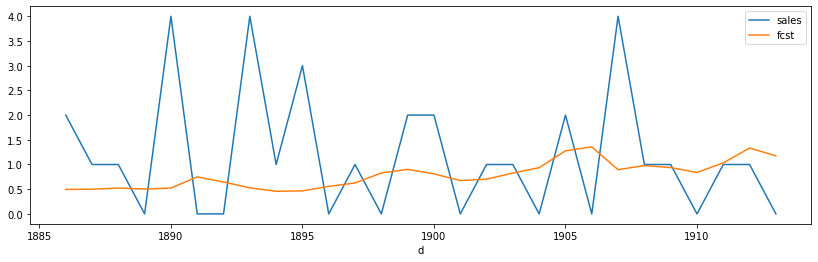

In [19]:
ID = 0
fcst_df.loc[val.id == ID, ["sales", "fcst", "d"]].set_index("d").plot()

<AxesSubplot:xlabel='d'>

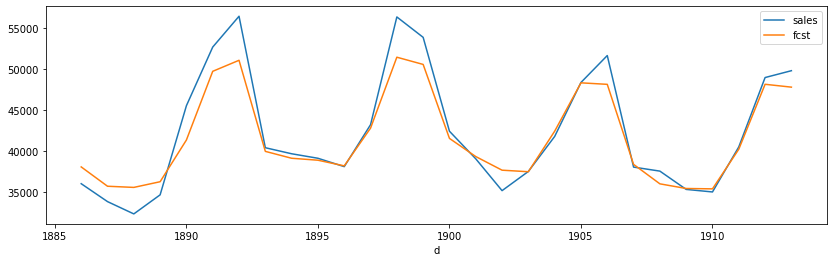

In [20]:
fcst_df.groupby(["d"])[["sales", "fcst"]].sum().plot()

In [21]:
fcst_bu = bottom_up_fcst(fcst_df)
fcst_bu

,id,d,sales,fcst
0,1,1886,36038.0,38081.034702
1,1,1887,33857.0,35728.811117
2,1,1888,32359.0,35586.739554
3,1,1889,34681.0,36278.601623
4,1,1890,45536.0,41359.586812
...,...,...,...,...
853713,12-3048-9,1909,0.0,0.099355
853714,12-3048-9,1910,0.0,0.084178
853715,12-3048-9,1911,0.0,0.089296
853716,12-3048-9,1912,0.0,0.107500


In [159]:
#fcst_pivot = pd.pivot(fcst_full, index="id", columns="d", values=["fcst"])

## Playground

In [10]:
train = train.iloc[:, :8]

In [12]:
id_cols = [col for col in train.columns if col.endswith("id")]

In [13]:
id_cols

['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43838692 entries, 493153 to 45087342
Data columns (total 8 columns):
 #   Column    Dtype
---  ------    -----
 0   sales     int16
 1   id        int16
 2   item_id   int16
 3   dept_id   int8 
 4   cat_id    int8 
 5   store_id  int8 
 6   state_id  int8 
 7   d         int16
dtypes: int16(4), int8(4)
memory usage: 836.2 MB


In [6]:
def bottom_up_fcst(fcst_base, cols):
    agg_level = {
        1: ['d'],
        2: ['state_id', 'd'],
        3: ['store_id', 'd'],
        4: ['cat_id', 'd'],
        5: ['dept_id', 'd'],
        6: ['state_id', 'cat_id', 'd'],
        7: ['state_id', 'dept_id', 'd'],
        8: ['store_id', 'cat_id', 'd'],
        9: ['store_id', 'dept_id', 'd'],
        10: ['item_id', 'd'],
        11: ['item_id', 'state_id', 'd'],
        12: ['item_id', 'store_id', 'd'],
    }
    
    fcst_level = dict()
    for k, agg_lvl in agg_level.items():
        fcst_agg = fcst_base.groupby(agg_lvl)[cols].sum().reset_index()
        id_cols = [col for col in fcst_agg.columns if col.endswith("id")]
        fcst_agg.insert(0, "id", str(k))
        for col in id_cols:
            fcst_agg["id"] = fcst_agg["id"] + "-" + fcst_agg[col].apply(str)
        fcst_level[k] = fcst_agg
    fcst_bu = pd.concat(fcst_level.values())[["id", "d"] + cols]
    return fcst_bu

In [ ]:
train_bu = bottom_up_fcst(train.iloc[:, :8], ["sales"])

In [24]:
fcst_df

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,fcst
45090392,0,0,0,0,0,0,1886,2,0.496003
45120882,0,0,0,0,0,0,1887,1,0.499167
45151372,0,0,0,0,0,0,1888,1,0.523483
45181862,0,0,0,0,0,0,1889,0,0.502798
45212352,0,0,0,0,0,0,1890,4,0.523306
...,...,...,...,...,...,...,...,...,...
45819102,30489,3048,6,2,9,2,1909,0,0.099355
45849592,30489,3048,6,2,9,2,1910,0,0.084178
45880082,30489,3048,6,2,9,2,1911,0,0.089296
45910572,30489,3048,6,2,9,2,1912,0,0.107500


In [208]:
agg_lvl[4]

IndexError: list index out of range

In [ ]:
def bottom_up_train(train_base):
    

In [16]:
train_gby = train.groupby(agg_level[4][:-1])["sales"].sum()

In [20]:
agg_level[4]

['cat_id', 'd']

In [21]:
train_gby.get_group(0)

493153      0
506481      1
519860      5
533275      0
546714      0
           ..
44966819    5
44997309    3
45027799    2
45058289    0
45088779    5
Name: sales, Length: 20366204, dtype: int16

In [178]:
fcst_bu = bottom_up_fcst(fcst_df)

In [204]:
agg_level[12][:-1]

['item_id', 'store_id']

In [184]:
train["sales"]

493153      0
506481      1
519860      5
533275      0
546714      0
           ..
44965382    0
44995872    0
45026362    0
45056852    0
45087342    0
Name: sales, Length: 43838692, dtype: int16

In [192]:
def bottom_up_agg(df, cols, fun):
    agg_level = {
        1: ['d'],
        2: ['state_id', 'd'],
        3: ['store_id', 'd'],
        4: ['cat_id', 'd'],
        5: ['dept_id', 'd'],
        6: ['state_id', 'cat_id', 'd'],
        7: ['state_id', 'dept_id', 'd'],
        8: ['store_id', 'cat_id', 'd'],
        9: ['store_id', 'dept_id', 'd'],
        10: ['item_id', 'd'],
        11: ['item_id', 'state_id', 'd'],
        12: ['item_id', 'store_id', 'd'],
    }
    df_level = dict()
    for k, agg_lvl in agg_level.items():
        df_agg = df.groupby(agg_lvl)[cols].agg(fun).reset_index()
        id_cols = [col for col in df_agg.columns if col.endswith("id")]
        df_agg.insert(0, "id", str(k))
        for col in id_cols:
            df_agg["id"] = df_agg["id"] + "-" + df_agg[col].apply(str)
        df_level[k] = df_agg
    df_bu = pd.concat(df_level.values())[["id", "d"] +  cols]
    return df_bu

In [202]:
train

,sales,id,item_id,dept_id,cat_id,store_id,state_id,d,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,sales_lag_1,sales_lag_2,sales_lag_3,sales_lag_4,sales_lag_5,sales_lag_6,sales_lag_7,sales_lag_8,sales_lag_9,sales_lag_10,sales_lag_11,sales_lag_12,sales_lag_13,sales_lag_14
493153,0,0,0,0,0,0,0,42,7,3,2011,0,0,0,0,0,1,1,2.00,1,3,0,0,0,0,2,0,2,4,1,0,0,3
506481,1,0,0,0,0,0,0,43,1,3,2011,0,0,0,0,0,1,1,2.00,3,1,3,0,0,0,0,2,0,2,4,1,0,0
519860,5,0,0,0,0,0,0,44,2,3,2011,0,0,0,0,0,1,0,2.00,0,3,1,3,0,0,0,0,2,0,2,4,1,0
533275,0,0,0,0,0,0,0,45,3,3,2011,0,0,0,0,0,0,1,2.00,2,0,3,1,3,0,0,0,0,2,0,2,4,1
546714,0,0,0,0,0,0,0,46,4,3,2011,0,0,0,0,0,1,1,2.00,1,2,0,3,1,3,0,0,0,0,2,0,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44965382,0,30489,3048,6,2,9,2,1881,5,3,2016,0,0,0,0,0,0,0,5.94,0,0,0,0,0,0,0,0,0,0,0,0,0,0
44995872,0,30489,3048,6,2,9,2,1882,6,3,2016,7,4,0,0,0,0,0,5.94,0,0,0,0,0,0,0,0,0,0,0,0,0,0
45026362,0,30489,3048,6,2,9,2,1883,7,3,2016,0,0,0,0,0,0,0,5.94,0,0,0,0,0,0,0,0,0,0,0,0,0,0
45056852,0,30489,3048,6,2,9,2,1884,1,3,2016,0,0,0,0,0,0,0,5.94,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
def insample_naive_mse(train):
    df_level = dict()
    for k, agg_lvl in agg_level.items():
        df_agg = df.groupby(agg_lvl)[cols].agg(fun).reset_index()
        id_cols = [col for col in df_agg.columns if col.endswith("id")]
        df_agg.insert(0, "id", str(k))
        for col in id_cols:
            df_agg["id"] = df_agg["id"] + "-" + df_agg[col].apply(str)
        df_level[k] = df_agg
    df_bu = pd.concat(df_level.values())[["id", "d"] +  cols]
    return df_bu

In [193]:
bottom_up_agg(fcst_df, ["sales", "fcst"], np.sum)

,id,d,sales,fcst
0,1,1886,36038.0,38081.034702
1,1,1887,33857.0,35728.811117
2,1,1888,32359.0,35586.739554
3,1,1889,34681.0,36278.601623
4,1,1890,45536.0,41359.586812
...,...,...,...,...
853713,12-3048-9,1909,0.0,0.099355
853714,12-3048-9,1910,0.0,0.084178
853715,12-3048-9,1911,0.0,0.089296
853716,12-3048-9,1912,0.0,0.107500


In [200]:
(fcst_bu["sales"] - fcst_bu["fcst"])**2

0         4.173991e+06
1         3.503677e+06
2         1.041830e+07
3         2.552331e+06
4         1.744243e+07
              ...     
853713    9.871392e-03
853714    7.085962e-03
853715    7.973776e-03
853716    1.155618e-02
853717    1.182962e-02
Length: 1199518, dtype: float64

In [ ]:
fcst_mse = 

In [201]:
insample_naive_mse = bottom_up_agg(train, cols=["sales"], fun=lambda x: (x.diff()**2).mean())

KeyboardInterrupt: 

In [196]:
denom = train.groupby(["item_id", "store_id"])["sales"].agg(lambda x: (x.diff()**2).mean())

In [197]:
denom

item_id  store_id
0        0            2.857298
         1            5.374932
         2           10.255562
         3            1.030402
         4            3.569490
                       ...    
3048     5            0.619978
         6            0.221378
         7            0.168478
         8            0.068660
         9            0.274701
Name: sales, Length: 30485, dtype: float32

In [183]:
train.iloc[:, :8].

,sales,id,item_id,dept_id,cat_id,store_id,state_id,d
493153,0,0,0,0,0,0,0,42
506481,1,0,0,0,0,0,0,43
519860,5,0,0,0,0,0,0,44
533275,0,0,0,0,0,0,0,45
546714,0,0,0,0,0,0,0,46
...,...,...,...,...,...,...,...,...
44965382,0,30489,3048,6,2,9,2,1881
44995872,0,30489,3048,6,2,9,2,1882
45026362,0,30489,3048,6,2,9,2,1883
45056852,0,30489,3048,6,2,9,2,1884


In [143]:
id_cols = [col for col in train.columns if col 
train.iloc[:, :8]

,sales,id,item_id,dept_id,cat_id,store_id,state_id,d
493153,0,0,0,0,0,0,0,42
506481,1,0,0,0,0,0,0,43
519860,5,0,0,0,0,0,0,44
533275,0,0,0,0,0,0,0,45
546714,0,0,0,0,0,0,0,46
...,...,...,...,...,...,...,...,...
44965382,0,30489,3048,6,2,9,2,1881
44995872,0,30489,3048,6,2,9,2,1882
45026362,0,30489,3048,6,2,9,2,1883
45056852,0,30489,3048,6,2,9,2,1884


In [85]:
scores = []
for k in val.id.unique():
    print(k, end="\r")
    y_train = train.loc[train.id == k, "sales"]
    y_val = val.loc[val.id == k, "sales"]
    y_fcst = val.loc[val.id == k, "fcst"]
    scores.append(rmsse(y_train, y_val, y_fcst))

In [94]:
scores = pd.Series(scores)

In [100]:
k = 12070
y_train = train.loc[train.id == k, "sales"]
y_val = val.loc[val.id == k, "sales"]
y_fcst = val.loc[val.id == k, "fcst"]

In [130]:
len(fcst_full.id.unique())

42840

In [117]:
fcst_full.isna().sum()

id       0
d        0
sales    0
fcst     0
dtype: int64

In [121]:
fcst_pivot = pd.pivot(fcst_full, index="id", columns="d", values=["fcst"])

In [125]:
fcst_pivot

fcst                                                          \
d               1886          1887          1888          1889          1890   
id                                                                             
1       38081.034702  35728.811117  35586.739554  36278.601623  41359.586812   
10-0        5.778170      5.512937      5.880830      5.787418      5.998307   
10-1        3.844203      3.842954      4.182444      4.480206      4.851929   
10-10      52.591573     50.741922     53.765664     54.205774     55.124642   
10-100      7.579782      7.244006      8.082507      7.964709      7.570153   
...              ...           ...           ...           ...           ...   
9-9-2    1709.791333   1568.582166   1616.415516   1688.429849   1988.229184   
9-9-3     228.863370    210.673729    215.487636    224.438783    252.610687   
9-9-4      27.833358     27.189374     28.197517     27.447334     26.827717   
9-9-5     626.352647    587.442341    593.467351    629.208705    741.749365   
9-9-6     144.946489    133.725850    134.830658    136.561797    157.282214   

                                                                              \
d               1891          1892          1893          1894          1895   
id                                                                             
1       49720.207379  51062.512004  39973.691002  39135.526662  38897.099921   
10-0        6.549523      6.816954      5.937779      5.550892      5.400049   
10-1        5.781533      5.778800      4.388615      4.151623      3.936835   
10-10      60.367633     57.849822     50.955219     52.087153     50.889368   
10-100      8.327884      8.067611      7.090946      7.830575      7.751707   
...              ...           ...           ...           ...           ...   
9-9-2    2595.744681   2605.563785   1911.283703   2033.791985   2032.677925   
9-9-3     283.245427    284.393020    230.343147    223.024396    218.790980   
9-9-4      30.783613     30.757370     25.423819     27.086872     27.907797   
9-9-5     864.485980    887.531417    680.215009    641.965389    647.273976   
9-9-6     187.419184    189.762205    146.223792    140.558957    140.529898   

                                                                              \
d               1896          1897          1898          1899          1900   
id                                                                             
1       38209.625306  42801.479386  51438.367446  50558.820631  41552.567777   
10-0        5.897740      6.038767      6.734651      6.318923      6.078331   
10-1        4.005090      4.131516      4.924578      5.136745      3.788700   
10-10      54.699514     53.794134     60.395064     57.412531     52.903384   
10-100      7.439803      7.828044     10.007888     11.426607      9.298319   
...              ...           ...           ...           ...           ...   
9-9-2    1858.915335   2226.238151   2670.408726   2427.562935   2198.959979   
9-9-3     218.175977    244.644861    283.088888    290.037497    234.649743   
9-9-4      26.678192     29.631561     34.447121     32.123171     28.609719   
9-9-5     639.626330    721.513921    856.880670    845.883779    659.118019   
9-9-6     137.323549    156.465245    184.244481    177.836677    146.515912   

                                                                              \
d               1901          1902          1903          1904          1905   
id                                                                             
1       39343.598642  37683.344646  37494.358632  42429.377412  48318.304043   
10-0        5.648875      5.466898      5.289436      5.714041      6.962586   
10-1        4.176894      3.881154      3.575388      3.879988      4.829056   
10-10      48.757403     52.648992     52.472401     54.994855     56.530342   
10-100      9.713377      8.989044      8.653030      8.674657     11.086674   
...          

In [113]:
fcst_full

,id,d,sales,fcst
0,1,1886,36038.0,38081.034702
1,1,1887,33857.0,35728.811117
2,1,1888,32359.0,35586.739554
3,1,1889,34681.0,36278.601623
4,1,1890,45536.0,41359.586812
...,...,...,...,...
853713,12-3048-9,1909,0.0,0.099355
853714,12-3048-9,1910,0.0,0.084178
853715,12-3048-9,1911,0.0,0.089296
853716,12-3048-9,1912,0.0,0.107500


In [110]:
len(fcst_full.id.unique())

42840

In [103]:
fcst_level["id", "d", "sales", "fcst"]

KeyError: ('id', 'd', 'sales', 'fcst')

,id,item_id,store_id,d,sales,fcst
1428,12-5-1,5,1,1886,0,1.046993
1429,12-5-1,5,1,1887,0,1.008089
1430,12-5-1,5,1,1888,0,0.955588
1431,12-5-1,5,1,1889,0,1.049652
1432,12-5-1,5,1,1890,0,1.319870
1433,12-5-1,5,1,1891,0,1.490537
1434,12-5-1,5,1,1892,0,1.826423
1435,12-5-1,5,1,1893,0,1.054284
1436,12-5-1,5,1,1894,1,1.513801
1437,12-5-1,5,1,1895,1,1.478957


In [88]:
df = fcst_level[12].copy()

In [89]:
df["id"] = "12"
for col in id_cols:
    df["id"] = df["id"] + "-" + df[col].apply(str)

In [90]:
df

,item_id,store_id,d,sales,fcst,id
0,0,0,1886,2,0.496003,12-0-0
1,0,0,1887,1,0.499167,12-0-0
2,0,0,1888,1,0.523483,12-0-0
3,0,0,1889,0,0.502798,12-0-0
4,0,0,1890,4,0.523306,12-0-0
...,...,...,...,...,...,...
853713,3048,9,1909,0,0.099355,12-3048-9
853714,3048,9,1910,0,0.084178,12-3048-9
853715,3048,9,1911,0,0.089296,12-3048-9
853716,3048,9,1912,0,0.107500,12-3048-9


In [80]:
ds = "12-" + df["item_id"].apply(str) + "-" + df["store_id"].apply(str)

In [81]:
ds[0]

'12-0-0'

In [76]:
df[id_cols].apply(lambda df: df[

AttributeError: 'DataFrame' object has no attribute 'str'

In [74]:
for col in id_cols:
    

['item_id', 'store_id']

In [68]:
fcst_level[11]

,item_id,state_id,d,sales,fcst
0,0,0,1886,4,3.551079
1,0,0,1887,1,3.192334
2,0,0,1888,2,3.436384
3,0,0,1889,0,3.204226
4,0,0,1890,4,3.344182
...,...,...,...,...,...
256111,3048,2,1909,0,0.235255
256112,3048,2,1910,1,0.210666
256113,3048,2,1911,0,0.244026
256114,3048,2,1912,0,0.305595


In [42]:
fcst_level[12].shape[0] / 28

30489.928571428572

In [46]:
853718 / 28

30489.928571428572

In [49]:
sizes = fcst_df.groupby("id").size()

In [50]:
sizes[sizes != 28]

id
12070    27
20218    27
dtype: int64

In [51]:
fcst_df[fcst_df.id == 12070]

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,fcst
45122089,12070,1207,2,0,0,0,1887,2,0.924491
45152579,12070,1207,2,0,0,0,1888,2,0.791392
45183069,12070,1207,2,0,0,0,1889,1,0.609281
45213559,12070,1207,2,0,0,0,1890,2,1.107247
45244049,12070,1207,2,0,0,0,1891,4,1.674150
45274539,12070,1207,2,0,0,0,1892,0,1.446395
45305029,12070,1207,2,0,0,0,1893,1,1.037771
45335519,12070,1207,2,0,0,0,1894,1,0.987013
45366009,12070,1207,2,0,0,0,1895,0,1.117287
45396499,12070,1207,2,0,0,0,1896,1,0.983557


In [43]:
fcst_level[12]

,item_id,store_id,d,sales,fcst
0,0,0,1886,2,0.496003
1,0,0,1887,1,0.499167
2,0,0,1888,1,0.523483
3,0,0,1889,0,0.502798
4,0,0,1890,4,0.523306
...,...,...,...,...,...
853713,3048,9,1909,0,0.099355
853714,3048,9,1910,0,0.084178
853715,3048,9,1911,0,0.089296
853716,3048,9,1912,0,0.107500


## Evaluate

In [22]:
fcst_bu

,id,d,sales,fcst
0,1,1886,36038.0,38081.034702
1,1,1887,33857.0,35728.811117
2,1,1888,32359.0,35586.739554
3,1,1889,34681.0,36278.601623
4,1,1890,45536.0,41359.586812
...,...,...,...,...
853713,12-3048-9,1909,0.0,0.099355
853714,12-3048-9,1910,0.0,0.084178
853715,12-3048-9,1911,0.0,0.089296
853716,12-3048-9,1912,0.0,0.107500


In [23]:
fcst_bu.id

0                 1
1                 1
2                 1
3                 1
4                 1
            ...    
853713    12-3048-9
853714    12-3048-9
853715    12-3048-9
853716    12-3048-9
853717    12-3048-9
Name: id, Length: 1199518, dtype: object

In [85]:
scores = []
for k in val.id.unique():
    print(k, end="\r")
    y_train = train.loc[train.id == k, "sales"]
    y_val = val.loc[val.id == k, "sales"]
    y_fcst = val.loc[val.id == k, "fcst"]
    scores.append(rmsse(y_train, y_val, y_fcst))

In [94]:
scores = pd.Series(scores)

In [100]:
k = 12070
y_train = train.loc[train.id == k, "sales"]
y_val = val.loc[val.id == k, "sales"]
y_fcst = val.loc[val.id == k, "fcst"]

In [109]:
len(train.id.unique())

30485

In [117]:
train[train.id == 13871]

,sales,id,item_id,dept_id,cat_id,store_id,state_id,d,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,sales_lag_1,sales_lag_2,sales_lag_3,sales_lag_4,sales_lag_5,sales_lag_6,sales_lag_7,sales_lag_8,sales_lag_9,sales_lag_10,sales_lag_11,sales_lag_12,sales_lag_13,sales_lag_14
39124267,0,13871,1387,2,0,1,0,1690,3,9,2015,0,0,0,0,0,0,1,2.28,0,0,1,0,0,1,1,0,1,2,0,1,0,1
39154665,0,13871,1387,2,0,1,0,1691,4,9,2015,0,0,0,0,0,1,1,2.28,0,0,0,1,0,0,1,1,0,1,2,0,1,0
39185063,0,13871,1387,2,0,1,0,1692,5,9,2015,0,0,0,0,0,0,0,2.28,0,0,0,0,1,0,0,1,1,0,1,2,0,1
39215461,0,13871,1387,2,0,1,0,1693,6,9,2015,0,0,0,0,0,0,0,2.28,0,0,0,0,0,1,0,0,1,1,0,1,2,0
39245861,0,13871,1387,2,0,1,0,1694,7,9,2015,0,0,0,0,0,0,0,2.28,0,0,0,0,0,0,1,0,0,1,1,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44942378,0,13871,1387,2,0,1,0,1881,5,3,2016,0,0,0,0,0,0,0,2.28,0,0,0,0,0,0,0,0,0,0,0,0,0,0
44972868,0,13871,1387,2,0,1,0,1882,6,3,2016,7,4,0,0,0,0,0,2.28,0,0,0,0,0,0,0,0,0,0,0,0,0,0
45003358,0,13871,1387,2,0,1,0,1883,7,3,2016,0,0,0,0,0,0,0,2.28,0,0,0,0,0,0,0,0,0,0,0,0,0,0
45033848,0,13871,1387,2,0,1,0,1884,1,3,2016,0,0,0,0,0,0,0,2.28,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [118]:
np.series

AttributeError: module 'numpy' has no attribute 'series'

In [120]:
scores[(scores != np.inf) & ~(scores.isna())].mean()

0.752522342842304

In [98]:
scores[scores.isna()]

12070   NaN
12072   NaN
20218   NaN
23923   NaN
23971   NaN
dtype: float64

In [92]:
np.isna(np.array(scores))

AttributeError: module 'numpy' has no attribute 'isna'

In [110]:
np.nanmean(np.array(scores))

inf

In [90]:
np.mean(np.array(scores))

nan

In [72]:
rmsse(y_train, y_val, y_fcst)

0.82342658074014

In [64]:
train

,sales,id,item_id,dept_id,cat_id,store_id,state_id,d,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,sales_lag_1,sales_lag_2,sales_lag_3,sales_lag_4,sales_lag_5,sales_lag_6,sales_lag_7,sales_lag_8,sales_lag_9,sales_lag_10,sales_lag_11,sales_lag_12,sales_lag_13,sales_lag_14
493153,0,0,0,0,0,0,0,42,7,3,2011,0,0,0,0,0,1,1,2.00,1,3,0,0,0,0,2,0,2,4,1,0,0,3
506481,1,0,0,0,0,0,0,43,1,3,2011,0,0,0,0,0,1,1,2.00,3,1,3,0,0,0,0,2,0,2,4,1,0,0
519860,5,0,0,0,0,0,0,44,2,3,2011,0,0,0,0,0,1,0,2.00,0,3,1,3,0,0,0,0,2,0,2,4,1,0
533275,0,0,0,0,0,0,0,45,3,3,2011,0,0,0,0,0,0,1,2.00,2,0,3,1,3,0,0,0,0,2,0,2,4,1
546714,0,0,0,0,0,0,0,46,4,3,2011,0,0,0,0,0,1,1,2.00,1,2,0,3,1,3,0,0,0,0,2,0,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44965382,0,30489,3048,6,2,9,2,1881,5,3,2016,0,0,0,0,0,0,0,5.94,0,0,0,0,0,0,0,0,0,0,0,0,0,0
44995872,0,30489,3048,6,2,9,2,1882,6,3,2016,7,4,0,0,0,0,0,5.94,0,0,0,0,0,0,0,0,0,0,0,0,0,0
45026362,0,30489,3048,6,2,9,2,1883,7,3,2016,0,0,0,0,0,0,0,5.94,0,0,0,0,0,0,0,0,0,0,0,0,0,0
45056852,0,30489,3048,6,2,9,2,1884,1,3,2016,0,0,0,0,0,0,0,5.94,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [40]:
fcst_df

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,fcst
45090392,0,0,0,0,0,0,1886,2,0.496003
45120882,0,0,0,0,0,0,1887,1,0.499167
45151372,0,0,0,0,0,0,1888,1,0.523483
45181862,0,0,0,0,0,0,1889,0,0.502798
45212352,0,0,0,0,0,0,1890,4,0.523306
...,...,...,...,...,...,...,...,...,...
45819102,30489,3048,6,2,9,2,1909,0,0.099355
45849592,30489,3048,6,2,9,2,1910,0,0.084178
45880082,30489,3048,6,2,9,2,1911,0,0.089296
45910572,30489,3048,6,2,9,2,1912,0,0.107500


In [48]:
fcst_lvl = dict()
for lvl, groups in levels.items():
    fcst_lvl[lvl] = fcst_df.groupby(levels[lvl])[["sales", "fcst"]].sum().reset_index()

<AxesSubplot:xlabel='d'>

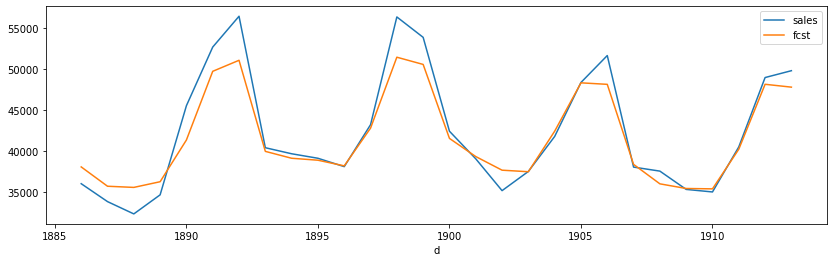

In [51]:
fcst_lvl[1].set_index("d").plot()

In [53]:
fcst_lvl[12]

,item_id,store_id,d,sales,fcst
0,0,0,1886,2,0.496003
1,0,0,1887,1,0.499167
2,0,0,1888,1,0.523483
3,0,0,1889,0,0.502798
4,0,0,1890,4,0.523306
...,...,...,...,...,...
853713,3048,9,1909,0,0.099355
853714,3048,9,1910,0,0.084178
853715,3048,9,1911,0,0.089296
853716,3048,9,1912,0,0.107500


In [54]:
sample = pd.read_csv(cfg.DATA_DIR / "sample_submission.csv")

In [57]:
sample

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60976,FOODS_3_824_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60977,FOODS_3_825_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60978,FOODS_3_826_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [56]:
len(sample) / 2

30490.0

In [43]:
fcst_lvl_12 = fcst_df.groupby(levels[12])[["sales", "fcst"]].sum().reset_index()

In [168]:
fcst_lvl_11 = fcst_df.groupby(levels[11])[["sales", "fcst"]].sum().reset_index()

In [44]:
fcst_lvl = fcst_df.groupby(levels[2])[["sales", "fcst"]].sum().reset_index()

In [45]:
fcst_lvl

,state_id,d,sales,fcst
0,0,1886,15481,16580.880754
1,0,1887,15319,15450.372737
2,0,1888,14352,15255.105235
3,0,1889,15601,15354.606207
4,0,1890,18922,17486.609612
...,...,...,...,...
79,2,1909,10595,10528.654313
80,2,1910,10943,10533.850675
81,2,1911,12807,12022.235225
82,2,1912,14862,14168.244796


<AxesSubplot:xlabel='d'>

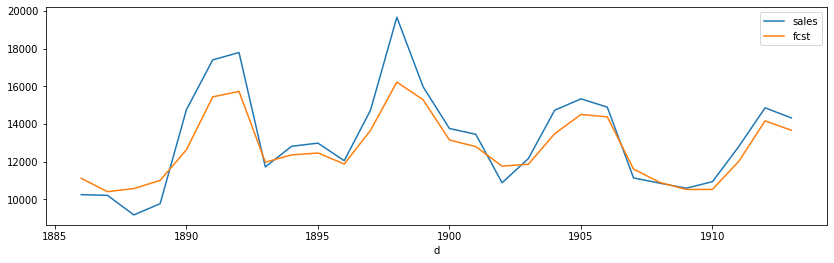

In [46]:
fcst_lvl.loc[(fcst_lvl.state_id == 2), ["d", "sales", "fcst"]].set_index("d").plot()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

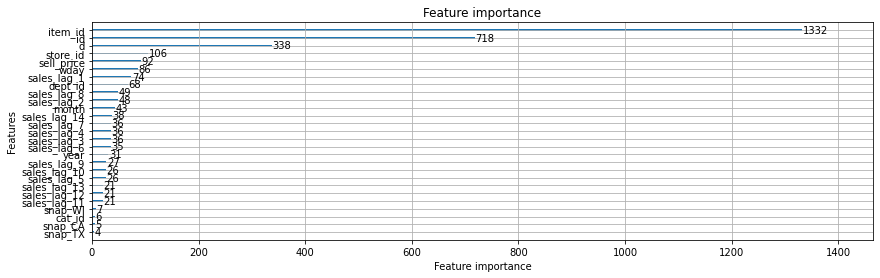

In [37]:
lgb.plot_importance(model)

In [79]:
len(pred_list)

28

In [75]:
np.concatenate(pred_list, axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [68]:
pred_list

[array([1.22661534, 0.88084717, 1.23830586, ..., 0.07606681, 0.02937654,
        0.08713963]),
 array([0.91013496, 0.79238071, 1.33617711, ..., 0.14340888, 0.05761701,
        0.1366027 ]),
 array([0.96446606, 0.82390982, 1.52428257, ..., 0.21276894, 0.0861157 ,
        0.20416952]),
 array([1.11600144, 0.84354012, 1.40061838, ..., 0.25783116, 0.11571528,
        0.27434642]),
 array([1.08991393, 0.7952713 , 1.53141526, ..., 0.3085512 , 0.13143741,
        0.31162161]),
 array([1.14317538, 0.93726515, 1.80252855, ..., 0.34491426, 0.14666852,
        0.34773267]),
 array([1.03611961, 1.04901208, 1.8178766 , ..., 0.34928281, 0.16663592,
        0.39507288]),
 array([1.06560194, 0.95359041, 1.59637921, ..., 0.3920908 , 0.18705877,
        0.44349288]),
 array([1.14117091, 0.98475649, 1.58061867, ..., 0.41112819, 0.19614113,
        0.46502602]),
 array([1.02875938, 1.01903147, 1.64762107, ..., 0.44322622, 0.21145447,
        0.50133202]),
 array([1.05668174, 1.02717939, 1.69328865, ..., 0

In [43]:
X_lags = X[lag_cols]

In [44]:
X_lags

,,sales_lag_1,sales_lag_2,sales_lag_3,sales_lag_4,sales_lag_5,sales_lag_6,sales_lag_7,sales_lag_8,sales_lag_9,sales_lag_10,sales_lag_11,sales_lag_12,sales_lag_13,sales_lag_14
id,,,,,,,,,,,,,,,
0,45090392,NaN,0,1,1,0,2,2,0,2,2,1,2,0,0
1,45093441,NaN,1,2,0,0,0,0,1,2,0,0,0,1,2
2,45096490,NaN,0,12,1,1,1,0,2,4,2,1,0,0,0
3,45099539,NaN,0,1,0,0,1,0,1,0,1,1,0,0,0
4,45102588,NaN,0,0,2,0,1,0,1,2,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,45105636,NaN,1,0,1,1,0,0,1,0,0,2,0,0,0
30486,45108685,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0
30487,45111734,NaN,0,0,0,0,0,0,0,0,1,0,0,0,0


204